<a href="https://colab.research.google.com/github/mtsizh/galaxy-morphology-manifold-learning/blob/main/nn_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

If you performed dataset curation on your own - upload `curated_imgs.zip` and skip to the next step. Otherwise you can run the following code and download the curated dataseet from GitHub.

In [1]:
!wget -q https://raw.githubusercontent.com/mtsizh/galaxy-morphology-manifold-learning/main/curated_dataset/curated_imgs_multipart.zip && echo "HEAD dowloaded" || "ERROR downloading HEAD"

for i in range(1,8):
  !wget -q https://raw.githubusercontent.com/mtsizh/galaxy-morphology-manifold-learning/main/curated_dataset/curated_imgs_multipart.z0{i}  && echo "PART {i} of 7 OK" || "ERROR downloading PART {i}"

print('MERGING PARTS')
!zip -FF curated_imgs_multipart.zip --out curated_imgs.zip > /dev/null && rm curated_imgs_multipart.z* && echo "COMPLETE" || "FAILED"


HEAD dowloaded
PART 1 of 7 OK
PART 2 of 7 OK
PART 3 of 7 OK
PART 4 of 7 OK
PART 5 of 7 OK
PART 6 of 7 OK
PART 7 of 7 OK
MERGING PARTS
COMPLETE


Unzip the curated dataset.

In [2]:
!unzip -q -o curated_imgs.zip && echo "UNZIPPED" || "FAIL"

UNZIPPED


Traing for 2 neural networks: convolutional and fully-connected.

In [26]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from PIL import Image
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.utils import to_categorical


# choose class map
class_map = {1: 'round', 2: 'inbetween', 3: 'cigar'}
#class_map = {4: 'edge on', 5: 'edge off'}
#class_map = {6: 'smooth', 7: 'featured'}

# choose neural network
network_type = "cnn"
#network_type = "fcn"

n_bootstrap_samples = 20000
train_epochs = 20


def load_images():
  df = pd.read_parquet('curated_dataset.parquet')
  regex_filter = '|'.join(class_map.values())
  filtered_df = df[df['class'].str.contains(regex_filter, regex=True)]
  bootstrapped_df = filtered_df.sample(n=n_bootstrap_samples)
  X = np.zeros((len(bootstrapped_df), 120, 120), dtype=float)
  y = np.zeros(len(bootstrapped_df))

  for key, val in class_map.items():
    y[bootstrapped_df['class'].str.contains(val, regex=True)] = key

  print('Dataset balance:')
  for k, v in class_map.items():
    print(f'class {v} has {np.sum(y == k)} items')
  print('-----------------------------------------')

  print('LOAD IMAGES')
  paths = bootstrapped_df['png_loc'].str.replace('dr5', 'curated_imgs')
  with tqdm(total=len(paths)) as progress:
    for idx, file_path in enumerate(paths):
      with Image.open(file_path) as img:
        X[idx, :, :] = np.array(img) / 255.0
        progress.update()
  return X, y


X, y = load_images()

network = models.Sequential()

if network_type == "cnn":
  print("Using CNN Model")
  X = X.reshape(-1, 120, 120, 1)
  network.add(layers.Input(shape=(120, 120, 1)))
  network.add(layers.Conv2D(32, (3, 3), activation='relu'))
  network.add(layers.MaxPooling2D((2, 2)))
  network.add(layers.Conv2D(64, (3, 3), activation='relu'))
  network.add(layers.MaxPooling2D((2, 2)))
  network.add(layers.Conv2D(128, (3, 3), activation='relu'))
  network.add(layers.MaxPooling2D((2, 2)))
  network.add(layers.Flatten())
  network.add(layers.Dense(128, activation='relu'))
  network.add(layers.Dense(len(class_map), activation='softmax'))  # Adjust for number of classes
elif network_type == "fcn":
  print("Using Multilayer Perceptron")
  X = X.reshape(X.shape[0], -1)
  network.add(layers.Input(shape=(X.shape[1],)))
  network.add(layers.Dense(128, activation='relu'))
  network.add(layers.Dense(64, activation='relu'))
  network.add(layers.Dense(len(class_map), activation='softmax'))
else:
  raise Exception("no such model")

y_categorical = to_categorical(y - np.min(y), num_classes=len(class_map))
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2)

network.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
network.fit(X_train, y_train, epochs=train_epochs, batch_size=32, validation_data=(X_test, y_test))
test_loss, test_acc = network.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_acc:.4f}")

# Save the model
cname = '_'.join(class_map.values())
model_filename = f'{cname}_model_{network_type}_dsize_{n_bootstrap_samples}.keras'.replace(' ', '_')
network.save(model_filename)
print(f"Model saved as {model_filename}")

Dataset balance:
class round has 6587 items
class inbetween has 10127 items
class cigar has 3286 items
-----------------------------------------
LOAD IMAGES


  0%|          | 0/20000 [00:00<?, ?it/s]

Using CNN Model
Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.6434 - loss: 0.7272 - val_accuracy: 0.9133 - val_loss: 0.2240
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9240 - loss: 0.2326 - val_accuracy: 0.9240 - val_loss: 0.2019
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.9287 - loss: 0.2057 - val_accuracy: 0.9230 - val_loss: 0.2036
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.9384 - loss: 0.1830 - val_accuracy: 0.9392 - val_loss: 0.1647
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.9422 - loss: 0.1703 - val_accuracy: 0.9495 - val_loss: 0.1454
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9407 - loss: 0.1567 - val_accuracy: 0.9492 - val_loss: 0.1447
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.9558 - loss: 0.1372 - val_accuracy: 0.9563 - val_loss: 0.1305
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.9573 - l

See statistics on all dumped neural networks. Names are expected to have format `{classes}_model_{cnn/fcn}_dsize_{train set size}.keras`. Expected value for `{classes}` is one of the following: `round_inbetween_cigar`, `edge_on_edge_off`, `smooth_featured`.

=================== CLASSES:  smooth_featured  MODEL:  fcn  TRAINED ON:  20000 =====================
Test Set balance:
class smooth has 10254 items
class featured has 9746 items
-----------------------------------------
LOAD IMAGES


  0%|          | 0/20000 [00:00<?, ?it/s]

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


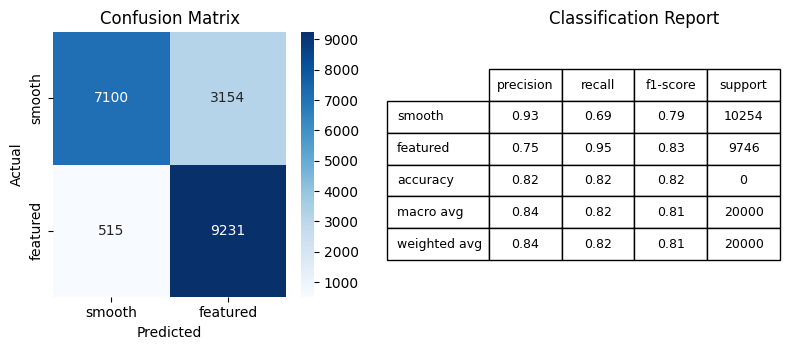

=================== CLASSES:  round_inbetween_cigar  MODEL:  fcn  TRAINED ON:  20000 =====================
Test Set balance:
class round has 6584 items
class inbetween has 10127 items
class cigar has 3289 items
-----------------------------------------
LOAD IMAGES


  0%|          | 0/20000 [00:00<?, ?it/s]

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


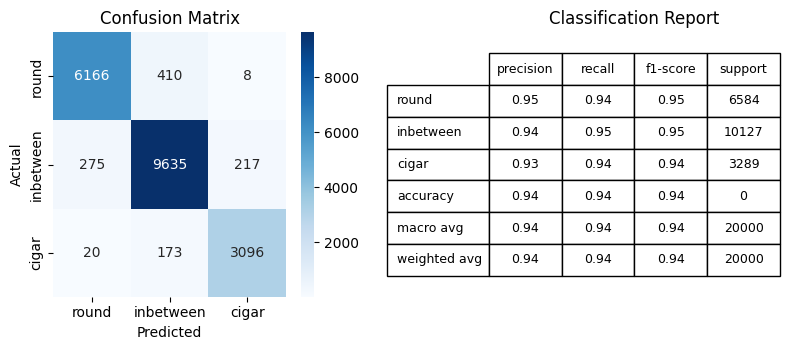

=================== CLASSES:  edge_on_edge_off  MODEL:  cnn  TRAINED ON:  20000 =====================
Test Set balance:
class edge on has 3450 items
class edge off has 16550 items
-----------------------------------------
LOAD IMAGES


  0%|          | 0/20000 [00:00<?, ?it/s]

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


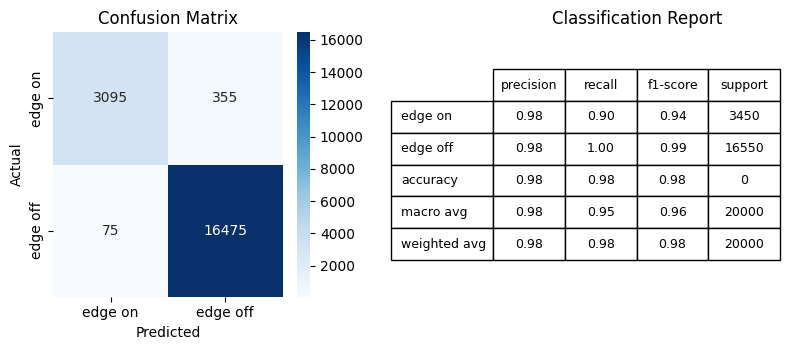

=================== CLASSES:  edge_on_edge_off  MODEL:  fcn  TRAINED ON:  20000 =====================
Test Set balance:
class edge on has 3418 items
class edge off has 16582 items
-----------------------------------------
LOAD IMAGES


  0%|          | 0/20000 [00:00<?, ?it/s]

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


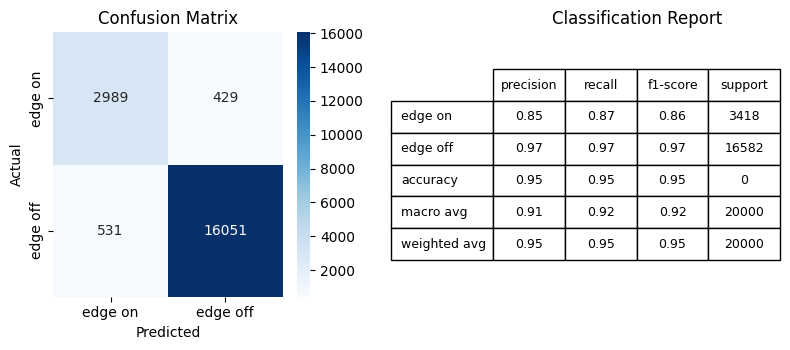

=================== CLASSES:  round_inbetween_cigar  MODEL:  cnn  TRAINED ON:  20000 =====================
Test Set balance:
class round has 6603 items
class inbetween has 10108 items
class cigar has 3289 items
-----------------------------------------
LOAD IMAGES


  0%|          | 0/20000 [00:00<?, ?it/s]

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


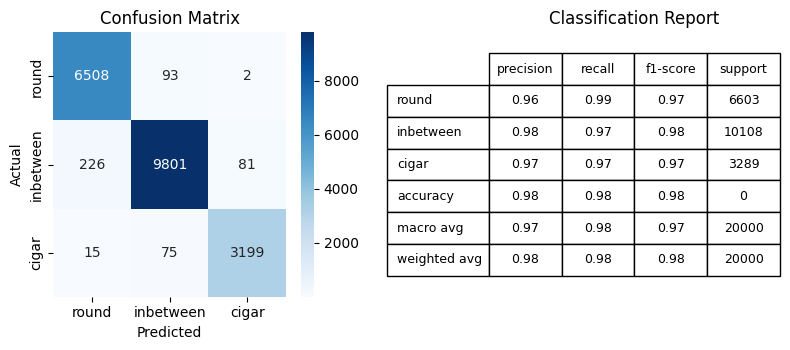

=================== CLASSES:  smooth_featured  MODEL:  cnn  TRAINED ON:  20000 =====================
Test Set balance:
class smooth has 10288 items
class featured has 9712 items
-----------------------------------------
LOAD IMAGES


  0%|          | 0/20000 [00:00<?, ?it/s]

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


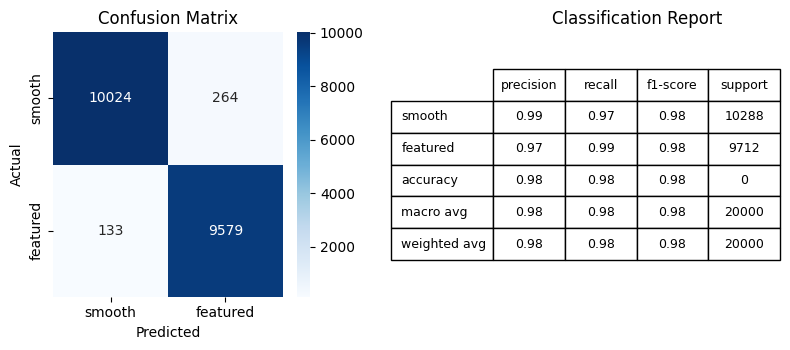

In [27]:
import os
import re
import glob
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras


test_size = 20000


def load_images(class_map):
  df = pd.read_parquet('curated_dataset.parquet')
  regex_filter = '|'.join(class_map.values())
  filtered_df = df[df['class'].str.contains(regex_filter, regex=True)]
  bootstrapped_df = filtered_df.sample(n=test_size)
  X = np.zeros((len(bootstrapped_df), 120, 120), dtype=float)
  y = np.zeros(len(bootstrapped_df))

  for key, val in class_map.items():
    y[bootstrapped_df['class'].str.contains(val, regex=True)] = key

  print('Test Set balance:')
  for k, v in class_map.items():
    print(f'class {v} has {np.sum(y == k)} items')
  print('-----------------------------------------')

  print('LOAD IMAGES')
  paths = bootstrapped_df['png_loc'].str.replace('dr5', 'curated_imgs')
  with tqdm(total=len(paths)) as progress:
    for idx, file_path in enumerate(paths):
      with Image.open(file_path) as img:
        X[idx, :, :] = np.array(img) / 255.0
        progress.update()
  return X, y

def get_predictions(model_file, model_type, X, y):
  if model_type == "cnn":
    X = X.reshape(-1, 120, 120, 1)
  elif model_type == "fcn":
    X = X.reshape(X.shape[0], -1)
  else:
    raise Exception("no such model type")
  y_categorical = to_categorical(y - np.min(y), num_classes=len(class_map))
  model = keras.models.load_model(model_file)
  predictions = model.predict(X)
  predicted_classes = np.argmax(predictions, axis=1) + np.min(y)
  return predicted_classes

def draw_heatmap_with_info(y_test, y_pred, width, height, clsnames):
    cm = confusion_matrix(y_test, y_pred, labels=list(clsnames.keys()))
    cm_df = pd.DataFrame(cm, index=list(clsnames.values()), columns=list(clsnames.values()))
    cm_arr = cm_df.to_numpy()

    class_report = classification_report(y_test, y_pred, output_dict=True,
                                         target_names=list(clsnames.values()), zero_division=1)
    class_report_df = pd.DataFrame(class_report).transpose()
    class_report_df['support'] = class_report_df['support'].astype(int)

    fig, axes = plt.subplots(1, 2, figsize=(width, height))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", ax=axes[0])
    axes[0].set_title("Confusion Matrix")
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("Actual")
    axes[1].axis('off')
    table = axes[1].table(
        cellText=class_report_df.map(lambda x: f"{x:.2f}" if isinstance(x, float) else x).values,
        rowLabels=class_report_df.index,
        colLabels=class_report_df.columns,
        cellLoc="center",
        loc="center",
    )
    table.scale(1, 2)
    axes[1].set_title("Classification Report")
    plt.tight_layout()
    plt.show()


model_files = glob.glob("*.keras")
for model_file in model_files:
  matched = re.match('(.*)_model_(.*)_dsize_([0-9]+)\.keras', model_file)
  if not matched:
    continue
  cls_map_name, model_type, train_size = matched[1], matched[2], int(matched[3])
  class_map = {
      'round_inbetween_cigar': {1: 'round', 2: 'inbetween', 3: 'cigar'},
      'edge_on_edge_off': {4: 'edge on', 5: 'edge off'},
      'smooth_featured': {6: 'smooth', 7: 'featured'}
  }[cls_map_name]
  print("=================== CLASSES: ", cls_map_name, " MODEL: ", model_type, " TRAINED ON: ", train_size, '=====================')
  X, y = load_images(class_map)
  y_pred = get_predictions(model_file, model_type, X, y)
  draw_heatmap_with_info(y, y_pred, width=8, height=3.6, clsnames=class_map)